In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import gym
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
from torch.distributions.categorical import Categorical

class PolicyNet(nn.Module):
    def  __init__(self, obs_dims, hl_dims, action_dims, lr):
        super(PolicyNet, self).__init__()
        self.obs_dims = obs_dims
        self.hl_dims = hl_dims
        self.action_dims = action_dims
        self.lr = lr

        self.model = nn.Sequential(
            nn.Linear(*self.obs_dims, self.hl_dims),
            nn.ReLU(),
            nn.Linear(self.hl_dims, self.hl_dims),
            nn.ReLU(),
            nn.Linear(self.hl_dims, self.action_dims),
            nn.Softmax(dim=-1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr = self.lr)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float)
        action_dist = self.model(x)
        action_dist = Categorical(action_dist)
        return action_dist
env = gym.make("CartPole-v0")
policy = PolicyNet(env.observation_space.shape, 40, np.array(env.action_space.n), 0.01)
def reward_to_go(rews, gamma):
    n = len(rews)
    rtgs = np.zeros_like(rews)
    rtgs_discounted = np.zeros_like(rews)
    for i in reversed(range(n)):
      rtgs[i] = rews[i] + (rtgs[i+1] if i+1 < n else 0)
    for i in range(len(rtgs)):
      rtgs_discounted[i] = (gamma**i)*rtgs[i]
    return rtgs_discounted - rtgs_discounted.mean()

rewards_per_episode = [] 
all_actions = [] 
all_obs = [] 
all_rewards = [] 

def store_memory(observation, reward, action):
    actions.append(action)
    observations.append(observation)
    rewards.append(reward)
env = gym.make("CartPole-v0")
policy = PolicyNet(env.observation_space.shape, 40, np.array(env.action_space.n), 0.01)
def train(batch_size):
    episodes = 400
    batch_counter = 1 
    
    def store_memory(observation, reward, action):
        actions.append(action)
        observations.append(observation)
        rewards.append(reward)

    for i in range(episodes):
        observation = env.reset()
        rewards = [] 
        actions = [] 
        observations = [] 
        done = False
        while done is False:
            action_dist = Categorical(policy.model(torch.tensor(observation, dtype=torch.float)))
            action = action_dist.sample().item()
            observation_, reward, done, info = env.step(action=action)
            store_memory(observation, reward, action)
            observation = observation_
        all_rewards.extend(reward_to_go(rewards, 0.99))
        all_obs.extend(observations)
        all_actions.extend(actions)
        rewards_per_episode.append(sum(rewards))
        batch_counter += 1 
        if batch_counter == batch_size:
            policy.optimizer.zero_grad()
            tensor_obs = torch.tensor(all_obs, dtype=torch.float)
            tensor_rewards = torch.tensor(all_rewards, dtype=torch.float)
            tensor_actions = torch.tensor(all_actions, dtype=torch.long)
            
            action_dist_log = torch.log(policy.model(tensor_obs))
            #print(action_dist_log.shape)
            #print(tensor_actions.shape, (np.arange(len(tensor_actions))).shape)
            selections = tensor_rewards * action_dist_log[(np.arange(len(tensor_rewards))), tensor_actions] 
            #print(len(tensor_rewards))
            loss = selections.mean()
            policy_loss = -loss
            policy_loss.backward()
            policy.optimizer.step()
            rewards = [] 
            actions = [] 
            observations = [] 
            batch_counter = 1 
        
        print("\repisode: {} Avg of last 10: {:2f}".format(episodes+ 1, np.mean(rewards_per_episode[-10:])), end=" ")
    return rewards_per_episode


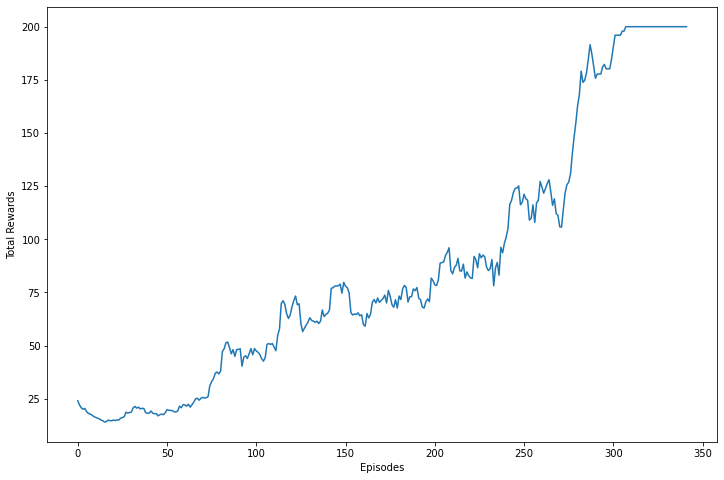

In [14]:
rewards = train(10)
reward_plot = [np.mean(rewards[i-10:i+1]) if i > 10 else np.mean(rewards[:i+1]) for i in range(len(rewards))]
plt.figure(figsize=(12,8))
plt.plot(smoothed_rewards)
plt.ylabel('Total Rewards')
plt.xlabel('Episodes')
plt.show()

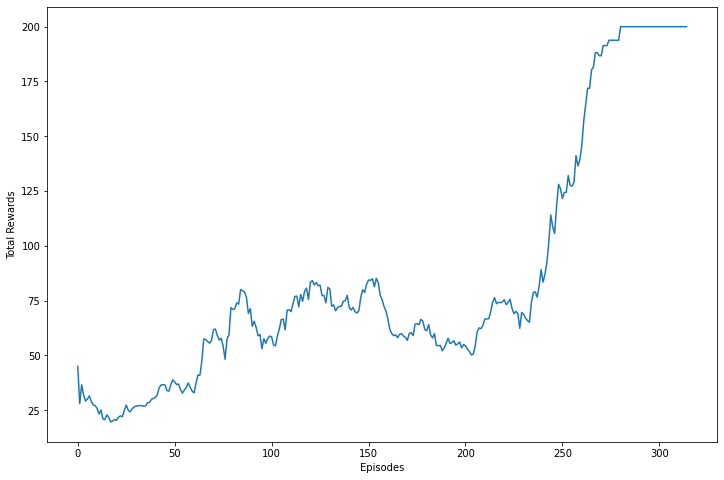

In [ ]:
#rewards = Agent.train(10)
rewards = rewards_per_episode
window = 10
smoothed_rewards = [np.mean(rewards[i-window:i+1]) if i > window 
                    else np.mean(rewards[:i+1]) for i in range(len(rewards))]

plt.figure(figsize=(12,8))
plt.plot(smoothed_rewards)
plt.ylabel('Total Rewards')
plt.xlabel('Episodes')
plt.show()

In [ ]:
play(gym.make('CartPole-v1'), 1)

TypeError: ignored